##### Notes:
- drop outliers
- only 2 years of data is not enough, makes no sense to consider time effects like seasonality, trend, etc. and treat the data as time-series
- generate more features: lags, logs

note for time series
- prophet model
- algorithms based on trees (xgboost in particular) are not good in predicting trend. we can predict trend using the linear model or smth else, then substract it from the series which will make it stationary, and then apply xgboost

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_log_error



In [2]:
# import warnings
# warnings.filterwarnings("ignore")

# from numpy import sort

# from datetime import datetime, timedelta, date
# plt.style.use('bmh')

# from sklearn.cluster import KMeans
# import plotly as py
# import plotly.offline as pyoff

# from sklearn.model_selection import KFold, cross_val_score, train_test_split
# from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score
# from mlxtend.feature_selection import SequentialFeatureSelector as sfs
# pyoff.init_notebook_mode()
# #import fbprophet as Prophet

# from scipy.stats import spearmanr

# from sklearn.model_selection import TimeSeriesSplit # train-test split for time-series

# import math

# Load and format data

In [3]:
# load data
# , index_col=['dteday']
days = pd.read_csv('../_data/day.csv', sep=',', decimal = ',', parse_dates=['dteday'])
hours = pd.read_csv('../_data/hour.csv', sep=',', decimal = ',', parse_dates=['dteday'])

# to date format
days = days.rename(columns = {"dteday": "date"})
hours = hours.rename(columns = {"dteday": "date"})

# to float 
columns = ['temp', 'atemp', 'hum', 'windspeed']

for column in days[columns]:
    days[column] = days[column].astype(float)
    
for column in hours[columns]:
    hours[column] = hours[column].astype(float)

In [4]:
hours.head()

,instant,date,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [5]:
hours.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     17379 non-null  int64         
 1   date        17379 non-null  datetime64[ns]
 2   season      17379 non-null  int64         
 3   yr          17379 non-null  int64         
 4   mnth        17379 non-null  int64         
 5   hr          17379 non-null  int64         
 6   holiday     17379 non-null  int64         
 7   weekday     17379 non-null  int64         
 8   workingday  17379 non-null  int64         
 9   weathersit  17379 non-null  int64         
 10  temp        17379 non-null  float64       
 11  atemp       17379 non-null  float64       
 12  hum         17379 non-null  float64       
 13  windspeed   17379 non-null  float64       
 14  casual      17379 non-null  int64         
 15  registered  17379 non-null  int64         
 16  cnt         17379 non-

# Constants

In [6]:
days_size = days.shape[0]
hours_size = hours.shape[0]

# EDA

In [7]:
days['cnt'].describe()   # [22, 8714] (mean = 4504)

count     731.000000
mean     4504.348837
std      1937.211452
min        22.000000
25%      3152.000000
50%      4548.000000
75%      5956.000000
max      8714.000000
Name: cnt, dtype: float64

In [8]:
hours['cnt'].describe() # [1, 977] (mean = 189)

count    17379.000000
mean       189.463088
std        181.387599
min          1.000000
25%         40.000000
50%        142.000000
75%        281.000000
max        977.000000
Name: cnt, dtype: float64

## Data consistency

No NaN values in the dataset

In [9]:
hours.isna().sum().sum()

0

We have full 2011-2012 history

In [10]:
days['yr'].value_counts().sort_index()

0    365
1    366
Name: yr, dtype: int64

At least one bike per hour is booked alsmot every day

In [11]:
hours.head()

,instant,date,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


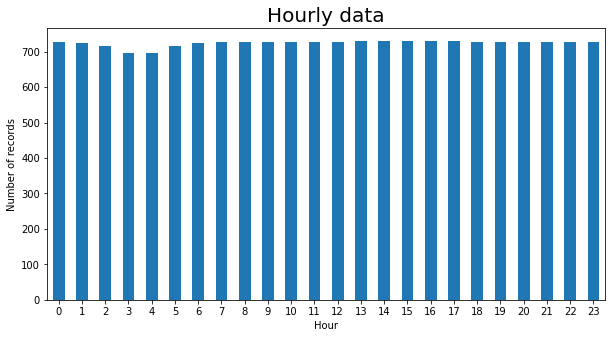

In [12]:
D = hours['hr'].value_counts().sort_index()

plt.figure(figsize=(10,5))
D.plot(kind = 'bar', rot=0)

plt.title("Hourly data", fontsize=20)
plt.xlabel('Hour')
plt.ylabel('Number of records')

plt.show()

## Dependence on weather conditions

$\textbf{'temp'}$ and $\textbf{'atemp'}$ are the same and correlate with 'cnt'. Thus, we must drop one of them to prevent overfitting.

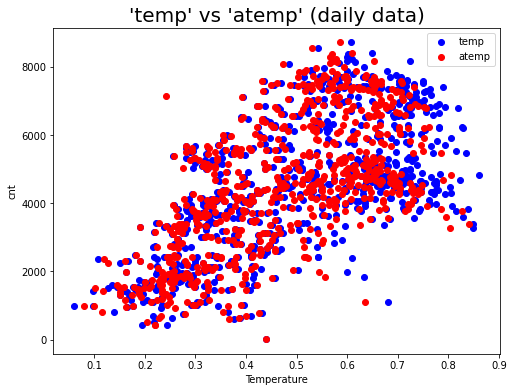

In [13]:
df, df_label = days, 'daily'
# df, df_label = hours, 'hourly'


plt.figure(figsize=(8,6))

plt.scatter(df['temp'], df['cnt'], color = 'blue')
plt.scatter(df['atemp'], df['cnt'], color = 'red')

plt.title("'temp' vs 'atemp' ({} data)".format(df_label), fontsize=20)
plt.legend(('temp', 'atemp'), loc='best')
plt.xlabel('Temperature')
plt.ylabel('cnt')

plt.show()

Weak correlation between $\textbf{humidity}$ / $\textbf{wind speed }$ and 'cnt'.

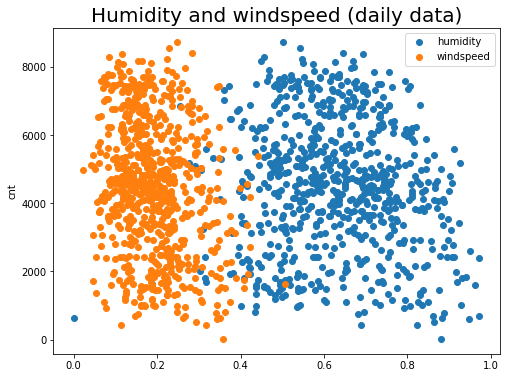

In [14]:
df, df_label = days, 'daily'
# df, df_label = hours, 'hourly'

plt.figure(figsize=(8,6))

plt.scatter(df['hum'], df['cnt'])
plt.scatter(df['windspeed'], df['cnt'])

plt.title("Humidity and windspeed ({} data)".format(df_label), fontsize = 20)
plt.legend(('humidity', 'windspeed'), loc='best')
# plt.xlabel('Temperature')
plt.ylabel('cnt')

plt.show()

$\textbf{Weather situation}$. Most of the time the weather is either excellent (>60%) or good. On average, twice more bikes are rented during this period. A slight correlation on 'weathersit' is expected.

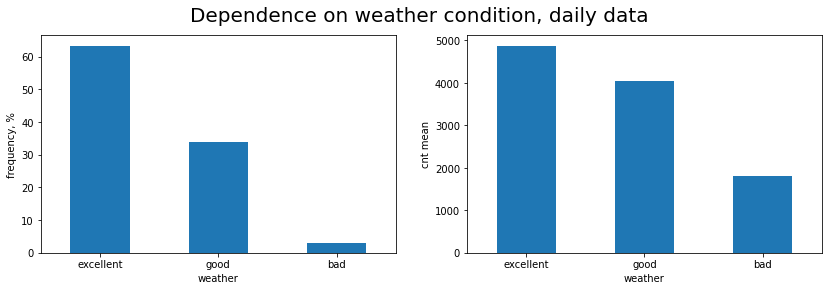

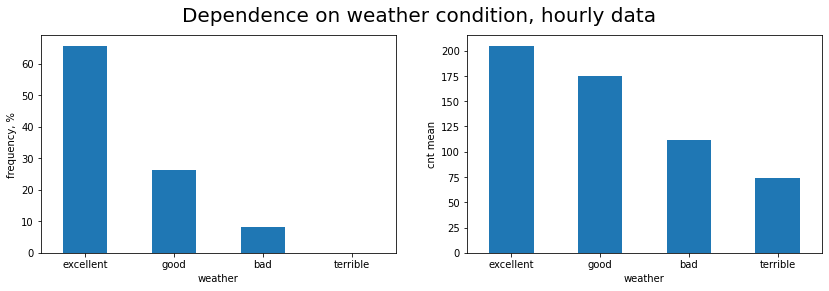

In [15]:
def plot_result(df, df_label):
    
    D1 = df['weathersit'].value_counts()/df['weathersit'].value_counts().sum()*100
    D2 = df.groupby('weathersit')['cnt'].mean()
    D_label = {1: 'excellent', 2: 'good', 3: 'bad', 4: 'terrible'}

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))

    fig.suptitle("Dependence on weather condition, {} data".format(df_label), fontsize=20)

    D1.plot(ax=ax1,kind='bar', rot = 0)
    D2.plot(ax=ax2,kind='bar', rot = 0)

    ax1.set(xlabel='weather', ylabel='frequency, %')
    xlabels = [D_label[key] for key in D1.keys()]
    ax1.set_xticklabels(xlabels)

    ax2.set(xlabel='weather', ylabel='cnt mean')
    xlabels = [D_label[key] for key in D2.keys()]
    ax2.set_xticklabels(xlabels)

    plt.show()


    
df, df_label = days, 'daily'
plot_result(df, df_label)

df, df_label = hours, 'hourly'
plot_result(df, df_label)

## Time dependence

$\textbf{Rent history}$

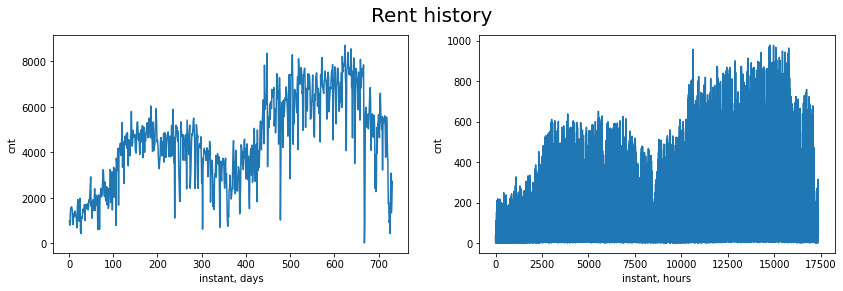

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))

fig.suptitle("Rent history", fontsize=20)

ax1.plot(days['instant'], days['cnt'])
ax2.plot(hours['instant'], hours['cnt'])

ax1.set(xlabel='instant, days', ylabel='cnt')
ax2.set(xlabel='instant, hours', ylabel='cnt')

plt.show()

$\textbf{Monthly distribution}$

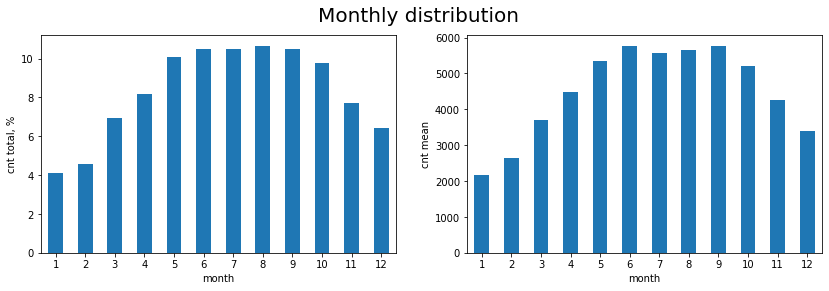

In [17]:
df, df_label = days, 'daily'

D1 = df.groupby('mnth')['cnt'].sum()/df['cnt'].sum()*100
D2 = df.groupby('mnth')['cnt'].mean()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))

fig.suptitle("Monthly distribution", fontsize=20)

D1.plot(ax=ax1,kind='bar', rot = 0)
D2.plot(ax=ax2,kind='bar', rot = 0)

ax1.set(xlabel='month', ylabel='cnt total, %')
ax2.set(xlabel='month', ylabel='cnt mean')

plt.show()

$\textbf{Seasonal distribution}$ is as expected. 

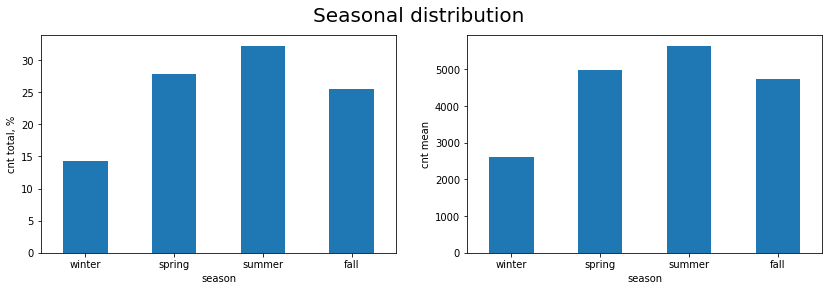

In [18]:
def plot_result(df, df_label):
    
    D1 = df.groupby('season')['cnt'].sum()/df['cnt'].sum()*100
    D2 = df.groupby('season')['cnt'].mean()
    D_label = {1: 'winter', 2: 'spring', 3: 'summer', 4: 'fall'}

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))

    fig.suptitle("Seasonal distribution".format(df_label), fontsize=20)

    D1.plot(ax=ax1,kind='bar', rot = 0)
    D2.plot(ax=ax2,kind='bar', rot = 0)

    ax1.set(xlabel='season', ylabel='cnt total, %')
    xlabels = [D_label[key] for key in D1.keys()]
    ax1.set_xticklabels(xlabels)

    ax2.set(xlabel='season', ylabel='cnt mean')
    xlabels = [D_label[key] for key in D2.keys()]
    ax2.set_xticklabels(xlabels)

    plt.show()

    
df, df_label = days, 'daily'
plot_result(df, df_label)

In [19]:
df.nunique()

instant       731
date          731
season          4
yr              2
mnth           12
holiday         2
weekday         7
workingday      2
weathersit      3
temp          499
atemp         690
hum           595
windspeed     650
casual        606
registered    679
cnt           696
dtype: int64

$\textbf{Days}$
- number of holidays is relatively small; 
- weekdays are uniformly distributed; 
- number of working days is twice bigger; 

In [20]:
columns = ['holiday', 'weekday', 'workingday']
for column in columns:
    print(column + ':')
    print({k: v for k, v in sorted(df[column].value_counts().to_dict().items())}, '\n')

holiday:
{0: 710, 1: 21} 

weekday:
{0: 105, 1: 105, 2: 104, 3: 104, 4: 104, 5: 104, 6: 105} 

workingday:
{0: 231, 1: 500} 



$\textbf{Week days}.$ Cnt is distributed homogeniously over the week days.

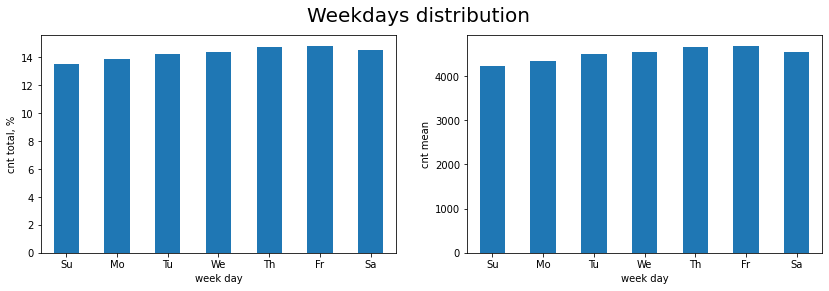

In [21]:
def plot_result(df, df_label):

    D1 = df.groupby('weekday')['cnt'].sum()/df['cnt'].sum()*100
    D2 = df.groupby('weekday')['cnt'].mean()
    D_label = {1: 'Mo', 2: 'Tu', 3: 'We', 4: 'Th', 5: 'Fr', 6: 'Sa', 0: 'Su'}

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))

    fig.suptitle("Weekdays distribution", fontsize=20)

    D1.plot(ax=ax1,kind='bar', rot = 0)
    D2.plot(ax=ax2,kind='bar', rot = 0)


    ax1.set(xlabel='week day', ylabel='cnt total, %')
    xlabels = [D_label[key] for key in D1.keys()]
    ax1.set_xticklabels(xlabels)

    ax2.set(xlabel='week day', ylabel='cnt mean')
    xlabels = [D_label[key] for key in D2.keys()]
    ax2.set_xticklabels(xlabels)

    plt.show()


df, df_label = days, 'daily'
plot_result(df, df_label)

$\textbf{Holidays}.$ Because of small number of holidays, no correlation.

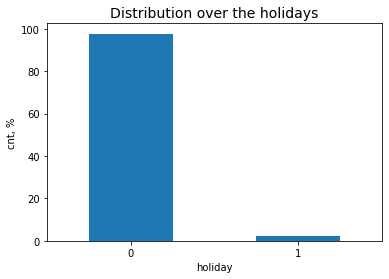

In [22]:
df, df_label = days, 'daily'

D = df.groupby('holiday')['cnt'].sum()/df['cnt'].sum()*100

plt.figure()
D.plot(kind = 'bar', rot=0)

plt.title("Distribution over the holidays", fontsize=14)
plt.xlabel('holiday')
plt.ylabel('cnt, %')

plt.show()

$\textbf{Hours}$. Peaks are around 8 am, when people go to work, and around 5-6 p.m., when people leave work place. 

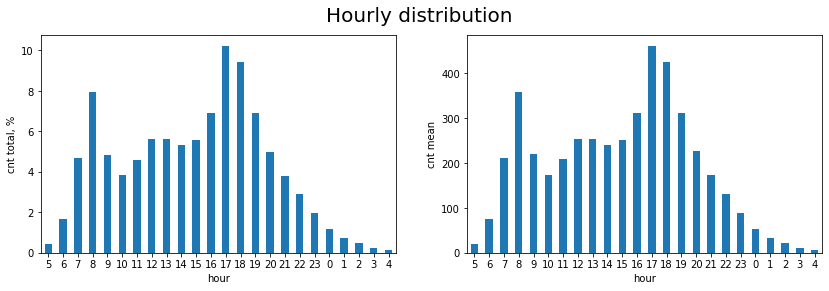

In [23]:
df, df_label = hours, 'hourly'

D1 = df.groupby('hr')['cnt'].sum()/df['cnt'].sum()*100
D2 = df.groupby('hr')['cnt'].mean()
D1 = D1[5:].append(D1[:5])
D2 = D2[5:].append(D2[:5])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))

fig.suptitle("Hourly distribution", fontsize=20)

D1.plot(ax=ax1,kind='bar', rot = 0)
D2.plot(ax=ax2,kind='bar', rot = 0)

ax1.set(xlabel='hour', ylabel='cnt total, %')
ax2.set(xlabel='hour', ylabel='cnt mean')

plt.show()

High amount of bike rents during the day is largerly due to the weekends and holidays.

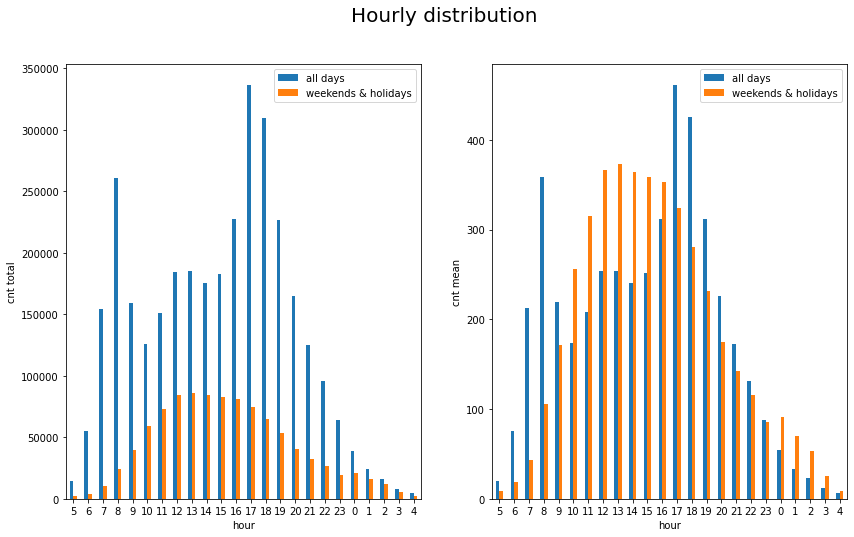

In [24]:
df, df_label = hours, 'hourly'

D1_f = df.groupby('hr')['cnt'].sum()
D2_f = df.groupby('hr')['cnt'].mean()
D1_nw = df[df.workingday == 0].groupby('hr')['cnt'].sum()
D2_nw = df[df.workingday == 0].groupby('hr')['cnt'].mean()
D1 = pd.DataFrame({'all days': D1_f,'weekends & holidays':D1_nw})
D2 = pd.DataFrame({'all days': D2_f,'weekends & holidays':D2_nw})
D1 = D1[5:].append(D1[:5])
D2 = D2[5:].append(D2[:5])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,8))

fig.suptitle("Hourly distribution", fontsize=20)

D1.plot(ax=ax1,kind='bar', rot = 0)
D2.plot(ax=ax2,kind='bar', rot = 0)

ax1.set(xlabel='hour', ylabel='cnt total')
ax2.set(xlabel='hour', ylabel='cnt mean')

plt.show()

## Registered vs casual customers

'cnt, 'registered' and 'casual' are linearly dependent as follows from the equation cnt = registered + casual.

We also see that evolution for casual customers have the same pattern as for registered. Thus, we must drop both 'registered' and 'casual' features to prevent overfitting.

In [25]:
days.casual.sum() + days.registered.sum() == days.cnt.sum()

True

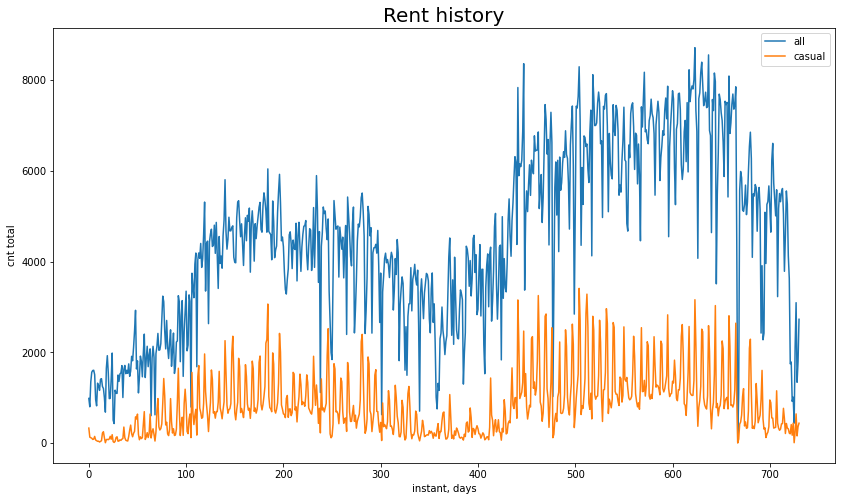

In [26]:
df, df_label = days, 'daily'

D = pd.DataFrame({'all': df.cnt,'casual':df.casual})

D.plot(figsize=(14,8))
plt.title("Rent history", fontsize=20)
plt.xlabel('instant, days')
plt.ylabel('cnt total')
plt.show()


## Correlation matrix

$\textbf{Pearson's correlation matrix}$

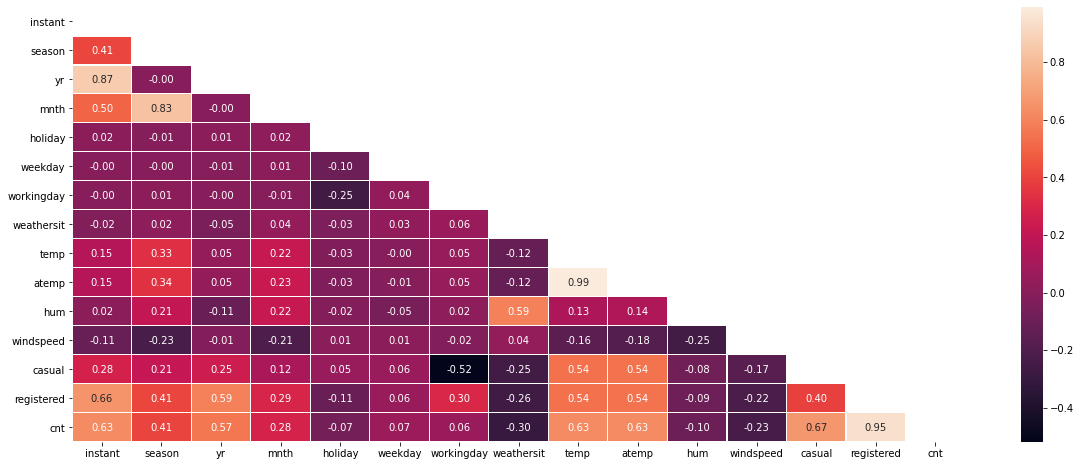

In [27]:
df = days

corr = df[df.columns].corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize = (20,8))
hm = sns.heatmap(corr, annot = True, mask=mask, linewidths=0.2, fmt=".2f")
bottom, top = hm.get_ylim()

$\textbf{Spearman's correlation}$ shows non-linear correlation between features.

Based on the analysis above and the correlation matrix:
- 'casual' and 'registered' are dropped since they are proportional to 'cnt': cnt = registered + casual
- 'temp' and 'atemp' are linearly dependent, so we drop one of them
- 'workingday' already contains information about holidays, weekends and weekdays; the information is partially lost, thus, we drop this feature and leave the rest. 


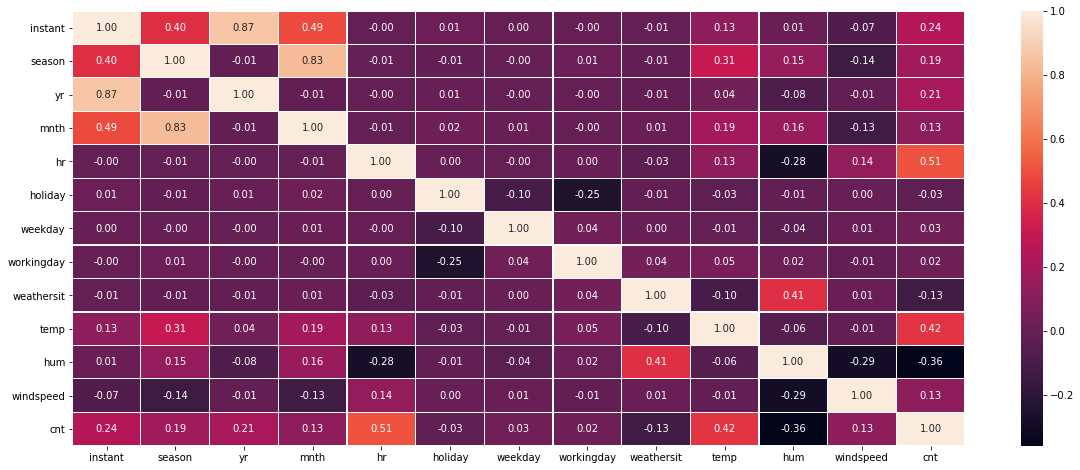

In [28]:
df = hours.drop(['casual', 'registered', 'atemp'], axis=1)

corr = df[df.columns].corr(method = 'spearman')
plt.figure(figsize = (20,8))
hm = sns.heatmap(corr, annot = True, linewidths=0.2, fmt=".2f")
bottom, top = hm.get_ylim()

# Prediction 

## Prepare the data

In [29]:
df = hours.copy()

# drop columns
cols_drop = ['instant', 'date', 'casual', 'registered', 'atemp', 'holiday']
df = df.drop(cols_drop, axis=1)


# categorical_vars = ['weathersit', 'workingday', 'season', 'yr', 'mnth', 'hr', 'weekday']
# for var in categorical_vars:
#     df[var] = df[var].astype("category")

    
# for var in ['weathersit', 'workingday', 'weekday', 'season', 'yr', 'mnth', 'hr']:
#     df_dummy = pd.get_dummies(df[var], prefix = var, drop_first = True)
#     df = pd.concat([df, df_dummy], axis = 1)
#     df = df.drop(var, axis=1)


# encode cyclic nature of time variables 
for var in ['season', 'mnth', 'weekday', 'hr']:
    df['sin_'+var] = np.round(np.sin(2*np.pi*df[var]/df[var].max()),3)
    df['cos_'+var] = np.round(np.cos(2*np.pi*df[var]/df[var].max()),3)
    df.drop(var, axis=1, inplace=True)
for var in ['weathersit']:
    df_dummy = pd.get_dummies(df[var], prefix = var, drop_first = True)
    df = pd.concat([df, df_dummy], axis = 1)
    df = df.drop(var, axis=1)   
    
# separate target variable
target = 'cnt'
y = np.log1p(df.pop(target))
X = df

df.head()

,yr,workingday,temp,hum,windspeed,sin_season,cos_season,sin_mnth,cos_mnth,sin_weekday,cos_weekday,sin_hr,cos_hr,weathersit_2,weathersit_3,weathersit_4
0,0,0,0.24,0.81,0.0,1.0,0.0,0.5,0.866,-0.0,1.0,0.000,1.000,0,0,0
1,0,0,0.22,0.80,0.0,1.0,0.0,0.5,0.866,-0.0,1.0,0.270,0.963,0,0,0
2,0,0,0.22,0.80,0.0,1.0,0.0,0.5,0.866,-0.0,1.0,0.520,0.854,0,0,0
3,0,0,0.24,0.75,0.0,1.0,0.0,0.5,0.866,-0.0,1.0,0.731,0.683,0,0,0
4,0,0,0.24,0.75,0.0,1.0,0.0,0.5,0.866,-0.0,1.0,0.888,0.460,0,0,0


In [30]:
# Add new features - shifts in time.
# for i in range(6, 25):
#     df["lag_{}".format(i)] = df.cnt.shift(i)

## Baseline

We will use the [RMSLE](https://medium.com/analytics-vidhya/root-mean-square-log-error-rmse-vs-rmlse-935c6cc1802a) metric for evaluating the results. 

In [31]:
def RMSLE(y, y_pred):
    """
        The Root Mean Squared Log Error (RMSLE) metric 
    """
    return np.sqrt(mean_squared_log_error(y, y_pred))

### Constant prediction

Constant prediction may serve as a naive baseline model. A model should at least perform better than this best RMSLE score.

best constant: 4.345755105809175 best rmsle: 0.31158


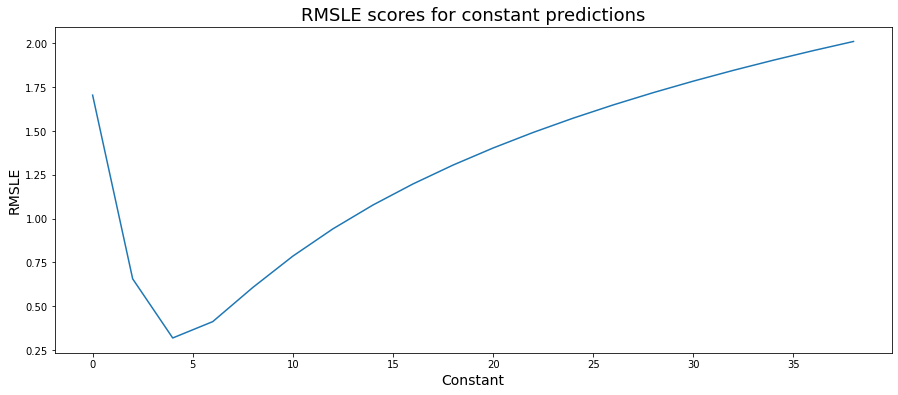

In [32]:
const_rmsles = dict()
for i in range(20):
    const = i*2
    rmsle = round(RMSLE(y, np.full(len(df), const)), 5)
    const_rmsles[const] = rmsle

xs = list(const_rmsles.keys())
ys = list(const_rmsles.values())

pd.DataFrame(ys, index=xs).plot(figsize=(15, 6), legend=None)
plt.title("RMSLE scores for constant predictions", fontsize=18)
plt.xlabel("Constant", fontsize=14)
plt.ylabel("RMSLE", fontsize=14);


best_const = np.expm1(np.mean(np.log1p(y)))
print('best constant:', best_const, 'best rmsle:', round(RMSLE(y, np.full(len(df), best_const)), 5))

### Other models

In [33]:
models = []
models.append(("LR",LinearRegression()))
models.append(("RF",RandomForestRegressor()))
models.append(("GB",GradientBoostingRegressor()))
models.append(("XGB",xgb.XGBRegressor()))

In [34]:
from sklearn.metrics import make_scorer
my_scorer = make_scorer(RMSLE)

for name, model in models:
    cv_result = cross_val_score(model, X, y, cv = 5, scoring = my_scorer)
    print(name, cv_result.mean())
    
# All categorical vars are of categorical type
# LR 0.2323572269962554
# RF 0.1036892825892414
# GB 0.10809085253401143

# All categorical vars are dummy
# LR 0.14364171699070255
# RF 0.1175649487829237
# GB 0.1308650788830068
# XGB 0.10460763710185668


# Time vars are cyclic, the rest is dummy
# LR 0.20802838181259614
# RF 0.10561069753590498
# GB 0.10999463054001812
# XGB 0.10302295848292493

LR 0.20802838181259617
RF 0.10504440200801987
GB 0.10993906385275518
XGB 0.1029726506601422


### Tuning parameters

### Feature Importance

In [35]:
# # Feature importance is strongly dependent on hyperparameters which are used in a model

# plt.figure(figsize = (10,10))

# sorted_idx = np.argsort(xgb_model.feature_importances_)[::-1]

# for index in sorted_idx:
#     print([X_train.iloc[:, feat_cols].columns[index], xgb_model.feature_importances_[index]])
    
# #feat_importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns)
# feat_importances = pd.Series(xgb_model.feature_importances_, index=X_train.iloc[:, feat_cols].columns)

# feat_importances.nlargest(100).plot(kind='barh')
# plt.show()
